In [80]:
import torch
import torch.nn.functional as F
import math
import numpy as np
import torch.nn as nn
import random

In [81]:
# Define 2-layer fully connected neural network with NTK parameterization

def _weights_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0, 1)


class FCNet(torch.nn.Module):
    def __init__(self, width, input_dimension):
        super(FCNet, self).__init__()
        self.width = width
        self.input_dimension = input_dimension
        self.fc1 = nn.Linear(input_dimension,width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)
        self.apply(_weights_init)

    def forward(self, x):
        x = x.view(-1, self.input_dimension)       
        x = 1/math.sqrt(self.input_dimension)*self.fc1(x)
        x = F.relu(x)
        x = 1/math.sqrt(self.width)*self.fc2(x)
        return x

In [48]:
# Set random seed

seed = 888
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps")

In [82]:
#Sample data

d = 100
train_size = 1000
test_size = 2000

def sample_data(num_samples):
    X = np.random.normal(size=(num_samples, d))
    y = X[:, 0] * X[:, 1]
    return X, y.reshape(-1, 1)

# n_train, n_test = 1000, 5000
X_train, y_train = sample_data(train_size)
X_test, y_test = sample_data(test_size)

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

trainset = list(zip(X_train, y_train))
testset = list(zip(X_test, y_test))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_size, shuffle=False, num_workers=1)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_size, shuffle=False, num_workers=1)

In [83]:
# computing AGOP: 1/n sum_i df/dxi df/dxi^T
def compute_agop(model):
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(train_loader):
                data = data.float().to(device)
                derivative = torch.sum(torch.autograd.functional.jacobian(model,data),dim = (1,2))
                agop = derivative.t()@derivative   
        return agop.cpu().numpy()

In [84]:
model = FCNet(width = 1024, input_dimension=d).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=8.0)

In [85]:
epoch = 500
train_losses = []

In [86]:
for i in range(1,epoch+1):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.float().to(device), target.float().to(device).view(-1,1)
            output = model(data)
            optimizer.zero_grad()
            # Compute loss and do backpropogation
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
            print(f'epoch:{i}, training loss:{loss.item()}')
            train_losses.append(loss.item())

epoch:1, training loss:1.4780044555664062
epoch:2, training loss:1.4061201810836792
epoch:3, training loss:1.3873051404953003
epoch:4, training loss:1.4774560928344727
epoch:5, training loss:1.8317679166793823
epoch:6, training loss:2.8650641441345215
epoch:7, training loss:5.671970844268799
epoch:8, training loss:13.104515075683594
epoch:9, training loss:32.398807525634766
epoch:10, training loss:80.64413452148438
epoch:11, training loss:190.39920043945312
epoch:12, training loss:383.0659484863281
epoch:13, training loss:523.97998046875
epoch:14, training loss:323.4353332519531
epoch:15, training loss:51.591392517089844
epoch:16, training loss:2.373793601989746
epoch:17, training loss:0.927416980266571
epoch:18, training loss:0.8948075175285339
epoch:19, training loss:0.8869109749794006
epoch:20, training loss:0.8796683549880981
epoch:21, training loss:0.8726484179496765
epoch:22, training loss:0.8658271431922913
epoch:23, training loss:0.8591927886009216
epoch:24, training loss:0.852

In [87]:
import matplotlib.pyplot as plt

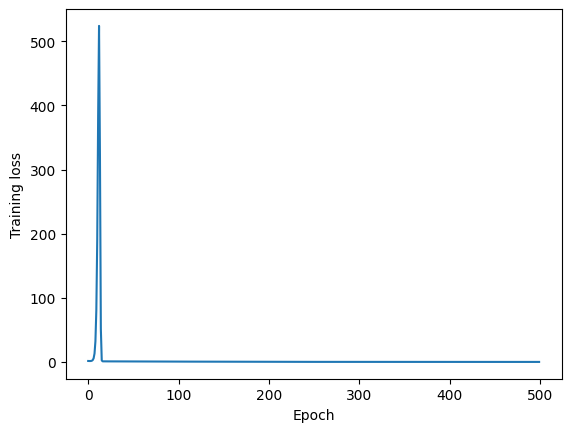

In [88]:
# Plot the total training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.show()

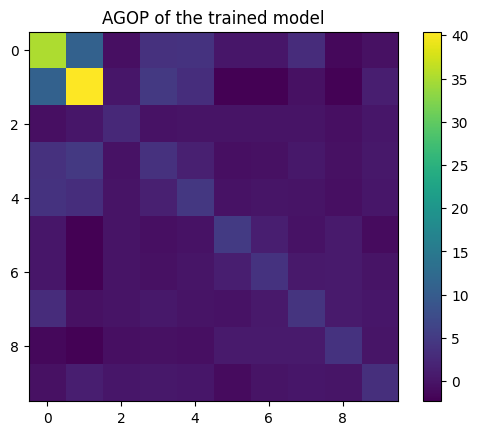

In [95]:
# computing AGOP of the model
agop = compute_agop(model)
plt.imshow(agop[:10,:10])
plt.colorbar()
plt.title('AGOP of the trained model')
plt.show()

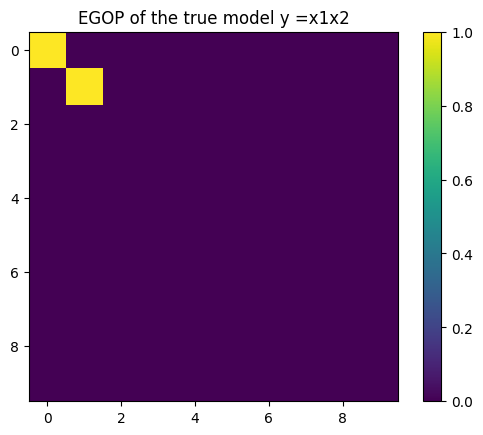

In [96]:
# EGOP of the target function y = x1x2
egop = np.zeros((d,d))
egop[0][0] = egop[1][1] = 1
plt.imshow(egop[:10,:10])
plt.colorbar()
plt.title('EGOP of the true model y =x1x2')
plt.show()